## Set up

In [2]:
import numpy as np
import os.path as op
from pprint import pformat
from typing import Tuple, Iterator
import time

# EEG utilities
import mne
from mne.preprocessing import ICA, create_eog_epochs
from pyprep.prep_pipeline import PrepPipeline
from autoreject import get_rejection_threshold, validation_curve

# BIDS utilities
from mne_bids import BIDSPath, read_raw_bids
from util.io.bids import DataSink
from bids import BIDSLayout

In [2]:
# Constants
BIDS_ROOT = '../data/bids'
DERIV_ROOT = '../data/bids/derivatives'
LOWPASS = 300
FS = 2000

## Functions
#### Import data 

In [3]:
# Create Iterator object to loop over all files
KeyType = Tuple[str, str, str]

def fpaths() -> Iterator[KeyType]:
    for sub in subjects:
        for task in tasks:
            for run in runs:
                run = str(run) # layout.get_runs() doesn't return strings for some reason
                key = (sub, task, run)
                yield key

def get_bids_path(bids_root, sub, task, run):
    bids_path = BIDSPath(root = bids_root,
                        subject = sub,
                        task = task,
                        run = run,
                        datatype = 'eeg',
                        )
    return bids_path

def import_bids_data(bids_path):
    raw = read_raw_bids(bids_path, verbose = False)
    raw = raw.pick_types(eeg = True)
    return raw

def read_events(raw):
    events, events_ids = mne.events_from_annotations(raw)
    return events, events_ids

#### Set electrode locations and create EOGs

In [4]:
def create_eogs(raw):
    raw = mne.set_bipolar_reference(raw, anode = 'Fp1', cathode = 'leog', ch_name = 'eog1', drop_refs = False)
    raw = mne.set_bipolar_reference(raw, anode = 'Fp2', cathode = 'reog', ch_name = 'eog2', drop_refs = False)
    raw = raw.drop_channels(['reog', 'leog'])
    raw = raw.set_channel_types({'eog1': 'eog', 'eog2': 'eog'})
    return raw

#### Resampling and PREP

In [5]:
def resample(raw, fs, events): # Resample to a more manageable speed
    raw, events = raw.resample(fs, events = events)
    return raw, events

def run_PREP(raw, sub, run, LOWPASS): # Run PREP pipeline (notch, exclude bad channels, and re-reference)
    raw.load_data()
    seed = int(str(sub) + str(run))
    np.random.seed(seed)

    lf = raw.info['line_freq']
    prep_params = {
        'ref_chs': 'eeg',
        'reref_chs': 'eeg',
        'line_freqs': np.arange(lf, LOWPASS, lf) if np.arange(lf, LOWPASS, lf).size > 0 else [lf]
    }
    prep = PrepPipeline(raw, prep_params, raw.get_montage(), ransac = False, random_state = seed)
    prep = prep.fit()

    raw = prep.raw_eeg # replace raw with cleaned version
    raw_non_eeg = prep.raw_non_eeg # return the eog
    raw = raw.add_channels([raw_non_eeg], force_update_info=True) # combine eeg and non eeg
    bads = prep.noisy_channels_original
    return raw, bads

#### Run ICA on one copy of the data
Split the data into two copies, one filtered more liberally for ICA so that high frequency noise can be detected, one band-pass filtered at the behaviorally relevant frequencies. All of the following preprocessing steps will be applied to each of the copies.

In [6]:
def bandpass(raw, h_freq, l_freq):
    raw = raw.filter(l_freq = l_freq, h_freq = h_freq)
    return raw

def epoch(raw):
    epochs = mne.Epochs(
        raw, 
        events, 
        tmin = -0.2, 
        tmax = 0.250, 
        baseline = None, # do NOT baseline correct the trials yet; we do that after ICA
        event_id = event_ids, # remember which epochs are associated with which condition
        preload = True # keep data in memory
    )
    return epochs

def compute_ICA(epochs):
    ica = ICA(n_components = 15, random_state = 0)
    ica = ica.fit(epochs, picks = ['eeg', 'eog'])
    return ica

def apply_ICA(epochs_for_ica, epochs):
    eog_indices, eog_scores = ica.find_bads_eog(epochs_for_ica, threshold = 1.96)
    ica.exclude = eog_indices
    epochs = ica.apply(epochs) # apply to aggressively filtered version of data
    return epochs, ica

#### Baseline correct and reject trials
Back to applying preprocessing on only one copy of the data. ICA is finished.

In [7]:
def baseline_correct(epochs):
    epochs = epochs.pick_types(eeg = True) # change syntax?
    epochs = epochs.apply_baseline((-0.2, 0.))
    return epochs

def reject_trials(epochs):
    thres = get_rejection_threshold(epochs)
    epochs = epochs.drop_bad(reject = thres)
    return epochs, thres

#### Save results and generate report

In [8]:
def get_save_path(deriv_root, sub, task, run):
    sink = DataSink(deriv_root, 'preprocessing')

    # save cleaned data
    fpath = sink.get_path(
                    subject = sub,
                    task = task, 
                    run = run,
                    desc = 'clean',
                    suffix = 'epo', # this suffix is following MNE, not BIDS, naming conventions
                    extension = 'fif.gz',
                    )
    return fpath, sink

def save_preprocessed_data(fpath, epochs):
    epochs.save(fpath, overwrite = True)
    
def generate_report(fpath, sink, epochs, ica, bads, thres):
    report = mne.Report(verbose = True)
    report.parse_folder(op.dirname(fpath), pattern = '*epo.fif.gz', render_bem = False)

    # Plot the ERP
    fig_erp = epochs['50'].average().plot(spatial_colors = True)
    report.add_figs_to_section(
        fig_erp, 
        captions = 'Average Evoked Response', 
        section = 'evoked'
    )

    # Plot the excluded ICAs
    if ica.exclude: # if we found any bad components
        fig_ica_removed = ica.plot_components(ica.exclude)
        report.add_figs_to_section(
            fig_ica_removed, 
            captions = 'Removed ICA Components', 
            section = 'ICA'
        )     
    
    # Format output
    html_lines = []
    for line in pformat(bads).splitlines():
        html_lines.append('<br/>%s' % line) 
    html = '\n'.join(html_lines)
    report.add_htmls_to_section(html, captions = 'Interpolated Channels', section = 'channels')
    report.add_htmls_to_section('<br/>threshold: {:0.2f} microvolts</br>'.format(thres['eeg'] * 1e6), 
                                captions = 'Trial Rejection Criteria', section = 'rejection')
    report.add_htmls_to_section(epochs.info._repr_html_(), captions = 'Info', section = 'info')
    report.save(op.join(sink.deriv_root, 'sub-%s.html'%sub), overwrite = True)

## Preprocessing wrapper
Since we have to loop over all the data files the section below will contain the for loop to wrap all the preprocessing functions contained in the subsequent sections.

['5', '4', '6', '3', '2'] ['pitch'] [1, 2]
---------- Import data ----------
../data/bids/sub-4/eeg/sub-4_task-pitch_run-1_eeg.vhdr
Used Annotations descriptions: ['100', '150', '200', '250', '50']
Reading 0 ... 5046249  =      0.000 ...  1009.250 secs...


/var/folders/hv/vj9_d69170l26hyj9hqqj45h0000gn/T/ipykernel_20817/1896026674.py:22: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog', 'Ch64', 'Aux1']
  raw = read_raw_bids(bids_path, verbose = False)
/var/folders/hv/vj9_d69170l26hyj9hqqj45h0000gn/T/ipykernel_20817/1896026674.py:22: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Aux1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5046250
    Range : 0 ... 5046249 =      0.000 ...  1009.250 secs
Ready.
Added the following bipolar channels:
eog1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=5046250
    Range : 0 ... 5046249 =      0.000 ...  1009.250 secs
Ready.
Added the following bipolar channels:
eog2
---------- Resampling and PREP ----------
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 sec)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-ph

2022-04-27 09:57:01,384 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['FC2', 'C1', 'CPz', 'C2'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['CPz', 'C1', 'C2', 'Cz', 'FC2']}
2022-04-27 09:58:17,874 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['Cz']}


Interpolating bad channels
    Automatic origin fit: head of radius 102.1 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors


2022-04-27 09:58:22,194 - pyprep.reference - INFO - Iterations: 1
2022-04-27 09:59:25,240 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['Cz']}


Interpolating bad channels
    Automatic origin fit: head of radius 102.1 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors


2022-04-27 09:59:29,665 - pyprep.reference - INFO - Iterations: 2
2022-04-27 10:00:32,283 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['Cz']}
2022-04-27 10:00:32,284 - pyprep.reference - INFO - Robust reference done


Interpolating bad channels
    Automatic origin fit: head of radius 102.1 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 sec)

Found 0 uniquely bad channels:

0 by NaN: []

0 by flat: []

0 by deviation: []

0 by HF noise: []

0 by correlation: []

0 by SNR: []

0 by dropout: []

0 by RANSAC: []

Interpolating bad channels
    Automatic origin fit: head of radius 102.1 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 1 sensors
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero

/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Selecting by number: 15 components
Fitting ICA took 46.8s.
Using EOG channels: eog1, eog2
Applying ICA to Epochs instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 63 PCA components
---------- Baseline correct and reject trials ----------
Applying baseline correction (mode: mean)
Estimating rejection dictionary for eeg
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'C4', 'FT10', 'FC6', 'F8', 'FT7', 'FC3', 'C5', 'C6', 'FC4', 'FT8', 'F6']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'C4', 'FC6', 'FT7', 'C6', 'FC4', 'FT8', 'F6']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['T7', 'T8']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T8']
   

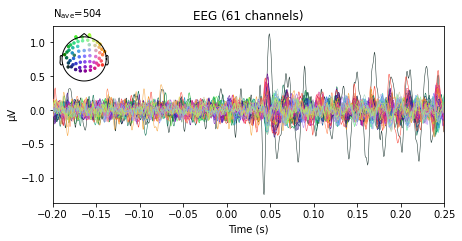

/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(li

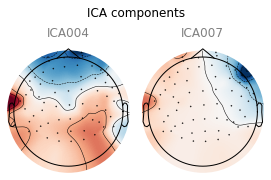

Saving report to : /Users/nusbaumlab/src/pitch_tracking/data/bids/derivatives/preprocessing/sub-4.html
---------- Import data ----------
../data/bids/sub-4/eeg/sub-4_task-pitch_run-2_eeg.vhdr
Used Annotations descriptions: ['100', '150', '200', '250', '50']
Reading 0 ... 4596749  =      0.000 ...   919.350 secs...


/var/folders/hv/vj9_d69170l26hyj9hqqj45h0000gn/T/ipykernel_20817/1896026674.py:22: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog', 'Ch64', 'Aux1']
  raw = read_raw_bids(bids_path, verbose = False)
/var/folders/hv/vj9_d69170l26hyj9hqqj45h0000gn/T/ipykernel_20817/1896026674.py:22: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Aux1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4596750
    Range : 0 ... 4596749 =      0.000 ...   919.350 secs
Ready.
Added the following bipolar channels:
eog1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=4596750
    Range : 0 ... 4596749 =      0.000 ...   919.350 secs
Ready.
Added the following bipolar channels:
eog2
---------- Resampling and PREP ----------
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 sec)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-ph

2022-04-27 10:12:37,949 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': [], 'bad_by_hf_noise': ['C2'], 'bad_by_correlation': ['AF3', 'C1', 'CPz'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['CPz', 'C1', 'C2', 'Cz', 'AF3']}
2022-04-27 10:13:45,694 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['AF3'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['Cz', 'AF3']}


Interpolating bad channels
    Automatic origin fit: head of radius 102.1 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors


2022-04-27 10:13:49,619 - pyprep.reference - INFO - Iterations: 1
2022-04-27 10:14:47,286 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['AF3'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['Cz', 'AF3']}


Interpolating bad channels
    Automatic origin fit: head of radius 102.1 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors


2022-04-27 10:14:51,242 - pyprep.reference - INFO - Iterations: 2
2022-04-27 10:15:47,460 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['AF3'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['Cz', 'AF3']}
2022-04-27 10:15:47,461 - pyprep.reference - INFO - Robust reference done


Interpolating bad channels
    Automatic origin fit: head of radius 102.1 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 sec)

Found 1 uniquely bad channels:

0 by NaN: []

0 by flat: []

0 by deviation: []

0 by HF noise: []

1 by correlation: ['AF3']

0 by SNR: []

0 by dropout: []

0 by RANSAC: []

Interpolating bad channels
    Automatic origin fit: head of radius 102.1 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass,

/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Selecting by number: 15 components
Fitting ICA took 69.9s.
Using EOG channels: eog1, eog2
Applying ICA to Epochs instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 63 PCA components
---------- Baseline correct and reject trials ----------
Applying baseline correction (mode: mean)
Estimating rejection dictionary for eeg
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'T7', 'FT7', 'C5']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'T7', 'FT7', 'C5']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'FT7']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'T7', 'FT7']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'T7', 'FT7', 'C5']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'FT7']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'FT7']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'FT7']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'FT7']
    Rejecting  epoch based on EEG

    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF4', 'F2', 'Cz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF4', 'F2', 'Cz']
    Rejecting  epoch based on EEG : ['Fp1', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'P3', 'P7', 'P4', 'P8', 'TP10', 'CP6'

    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT9', 'FC5', 'C3', 'T7', 'TP9', 'CP5', 'P3', 'FT7', 'FC3', 'C5', 'TP7', 'CP3', 'P5']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT9', 'FC5', 'C3', 'T7', 'TP9', 'CP5', 'P3', 'FT7', 'FC3', 'C5', 'TP7', 'CP3', 'P5']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'P3', 'FT7', 'FC3', 'C5', 'TP7', 'CP3', 'P5']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'FT7', 'FC3', 'C5', 'TP7', 'CP3', 'P5']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'P3', 'FT7', 'FC3', 'C5', 'TP7', 'CP3', 'P5']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'P3', 'FT7', 'FC3', 'C5', 'TP7', 'CP3', 'P5']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT9', 'FC5', 'C3', 'T7', 'TP9', 'CP5', 'P3', 'FT7', 'FC3', 'C5', 'TP7', 'CP3', 'P5']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT9', 'FC5', 'C3', 'T7', 'TP9', 'CP5', 'P3', 'F5', '

    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'FT7', 'FC3', 'C5', 'TP7', 'CP3', 'P5']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'P3', 'FT7', 'FC3', 'C5', 'TP7', 'CP3', 'P5']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'P3', 'FT7', 'FC3', 'C5', 'TP7', 'CP3', 'P5']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'FT7', 'FC3', 'C5', 'TP7', 'CP3', 'P5']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'FT7', 'C5', 'TP7']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'CP5', 'FT7', 'C5']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'T7', 'CP5', 'FT7', 'C5', 'CP3']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'CP5', 'FT7', 'C5', 'CP3', 'P5']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'CP5', 'FT7', 'C5']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'CP5', 'FT7', 'C5']
    Rejecting  ep

    Rejecting  epoch based on EEG : ['FC5', 'FT7']
    Rejecting  epoch based on EEG : ['FC5', 'FT7']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'FT7']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'FT7', 'C5']
    Rejecting  epoch based on EEG : ['FC5', 'FT7']
    Rejecting  epoch based on EEG : ['FC5', 'FT7']
    Rejecting  epoch based on EEG : ['FC5', 'FT7']
    Rejecting  epoch based on EEG : ['FC5', 'FT7']
    Rejecting  epoch based on EEG : ['FC5', 'FT7']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5', 'FT7']
    Rejecting  epoch based on EEG : ['FC5', 'FT7']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'FT7']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'FT7', 'C5']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'FT7']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'FT7', 'C5']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'FT7', 'C5']
    R

    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'CP5', 'FT7', 'C5']
    Rejecting  epoch based on EEG : ['FC5', 'T7', 'CP5', 'FT7']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'FT7']
    Rejecting  epoch based on EEG : ['FC5', 'T7', 'CP5', 'FT7']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'CP5', 'FT7', 'C5']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'CP5', 'FT7', 'C5']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'CP5', 'FT7', 'C5']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'CP5', 'FT7', 'C5']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'CP5', 'FT7']
    Rejecting  epoch based on EEG : ['FC5', 'T7', 'FT7']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'FT7', 'C5']
    Rejecting  epoch based on EEG : ['FC5', 'FT7']
    Rejecting  epoch based on EEG : ['FC5', 'FT7']
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['FC5', 'FT7']
    Rejecting  epoch based on EEG 

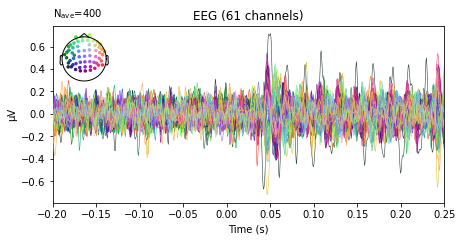

/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(li

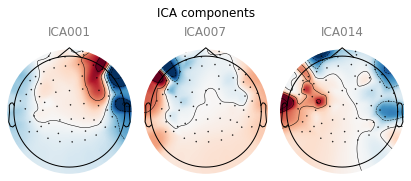

Overwriting existing file.
Saving report to : /Users/nusbaumlab/src/pitch_tracking/data/bids/derivatives/preprocessing/sub-4.html
1909.4722192287445


In [9]:
start = time.time()

# Parse BIDS directory
layout = BIDSLayout(BIDS_ROOT)
subjects = layout.get_subjects()
tasks = layout.get_tasks()
runs = layout.get_runs()
print(subjects, tasks, runs)

for (sub, task, run) in fpaths():
    
    # Import data
    print("---------- Import data ----------")
    bids_path = get_bids_path(BIDS_ROOT, sub, task, run)
    print(bids_path)
    if not bids_path.fpath.is_file(): # skip if file doesn't exist
        continue
    raw = import_bids_data(bids_path)
    events, event_ids = read_events(raw)

    # Create virtual EOGs
    raw.load_data()
    raw = create_eogs(raw)
    
    if sub == '4':
        raw = raw.drop_channels(['Ch64']) # drop channel with no coordinates for sub 4
    
    # Resampling and PREP
    print("---------- Resampling and PREP ----------")
    raw, events = resample(raw, FS, events)
    raw, bads = run_PREP(raw, sub, run, LOWPASS)

    # Run ICA on one copy of the data
    print("---------- Run ICA on one copy of the data ----------")
    raw_for_ica = bandpass(raw, None, 1)
    raw = bandpass(raw, 270, 30)
    
    epochs_for_ica = epoch(raw_for_ica)
    epochs = epoch(raw)
    
    ica = compute_ICA(epochs_for_ica) # run ICA on less aggressively filtered data
    epochs, ica = apply_ICA(epochs_for_ica, epochs) # apply ICA on more aggressively filtered data
    
    # Baseline correct and reject trials
    print("---------- Baseline correct and reject trials ----------")
    epochs = baseline_correct(epochs)
    epochs, thres = reject_trials(epochs)
    
    # Save results and generate report
    print("---------- Save results and generate report ----------")
    fpath, sink = get_save_path(DERIV_ROOT, sub, task, run)
    save_preprocessed_data(fpath, epochs)
    generate_report(fpath, sink, epochs, ica, bads, thres)
    
end = time.time()
print(end - start)

In [8]:
layout = BIDSLayout('../data/bids')
layout.get_subjects()

ValueError: BIDS root does not exist: /Users/letitiaho/src/pitch-tracking/preprocessing/../data/bids